In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Convolutional Neural Network
### Fashion MNIST Dataset

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from collections.abc import Callable
from typing import Literal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 

%matplotlib inline

2023-12-04 12:53:07.044498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# gpus = tf.config.list_physical_devices('GPU')

# try:
#     for g in gpus:
#         tf.config.experimental.set_memory_growth(g, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print (len(gpus), 'Phusical GPUs', len(logical_gpus), 'Logical GPUs')
# except:
#     print ('invalid device')

In [4]:
###----------------
### Some parameters
###----------------

inpDir = '../../input'
outDir = '../output'
subDir = 'Shakespeare'
modelDir = '.../models'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 10 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 32
LR_PATIENCE = 2
FACTOR_LR = 0.5
TRAIN_SIZE = 256 # fix size of train set sot that we have batches of same size
PATIENCE = 4

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

In [5]:


def fn_plot_label(train_df : pd.DataFrame, test_df : pd.DataFrame):
    
    plt.figure(figsize=(15,5))
    
    plt.plot(1,2,1)
    
    ax = train_df['label'].value_counts().plot(kind='bar',
                                               title= 'Training distribution',
                                               color= 'DarkBlue', alpha= 0.8)
    
    plt.subplot(1,2,2)
    
    ax = test_df['label'].value_counts().plot(kind='bar',
                                               title= 'Testing distribution',
                                               color= 'Orange', alpha= 0.8)


## Generate Data Set
Fashion MINST Dataset

In [6]:
class_label = {0 : 'T-shirt/Top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'}

In [7]:
train_df = pd.read_csv('fashion-mnist_train.csv', header=0)

test_df = pd.read_csv('fashion-mnist_test.csv', header=0)

In [8]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


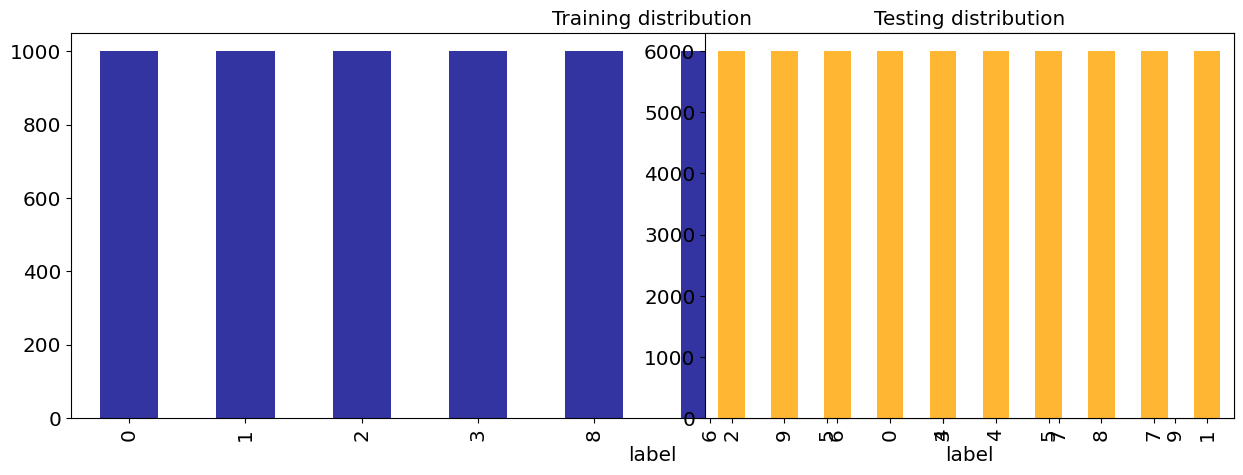

In [10]:
fn_plot_label(test_df, train_df)

### Converting to Datasets

In [11]:
def fn_split_feature_labels (row):
    
    feature = tf.reshape(row[1:], [28,28,1])
    
    label = row[0]
    
    return feature, label


In [12]:
# Create a training dataset

#--------------
# Traning Data
#--------------

tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(fn_split_feature_labels)

train_ds = train_ds.batch(BATCH_SIZE)
#--------------
# Testing Data
#--------------

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(fn_split_feature_labels)

test_ds = test_ds.batch(BATCH_SIZE)


2023-12-04 12:53:14.596624: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2023-12-04 12:53:15.576633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [60000,785]
	 [[{{node Placeholder/_0}}]]


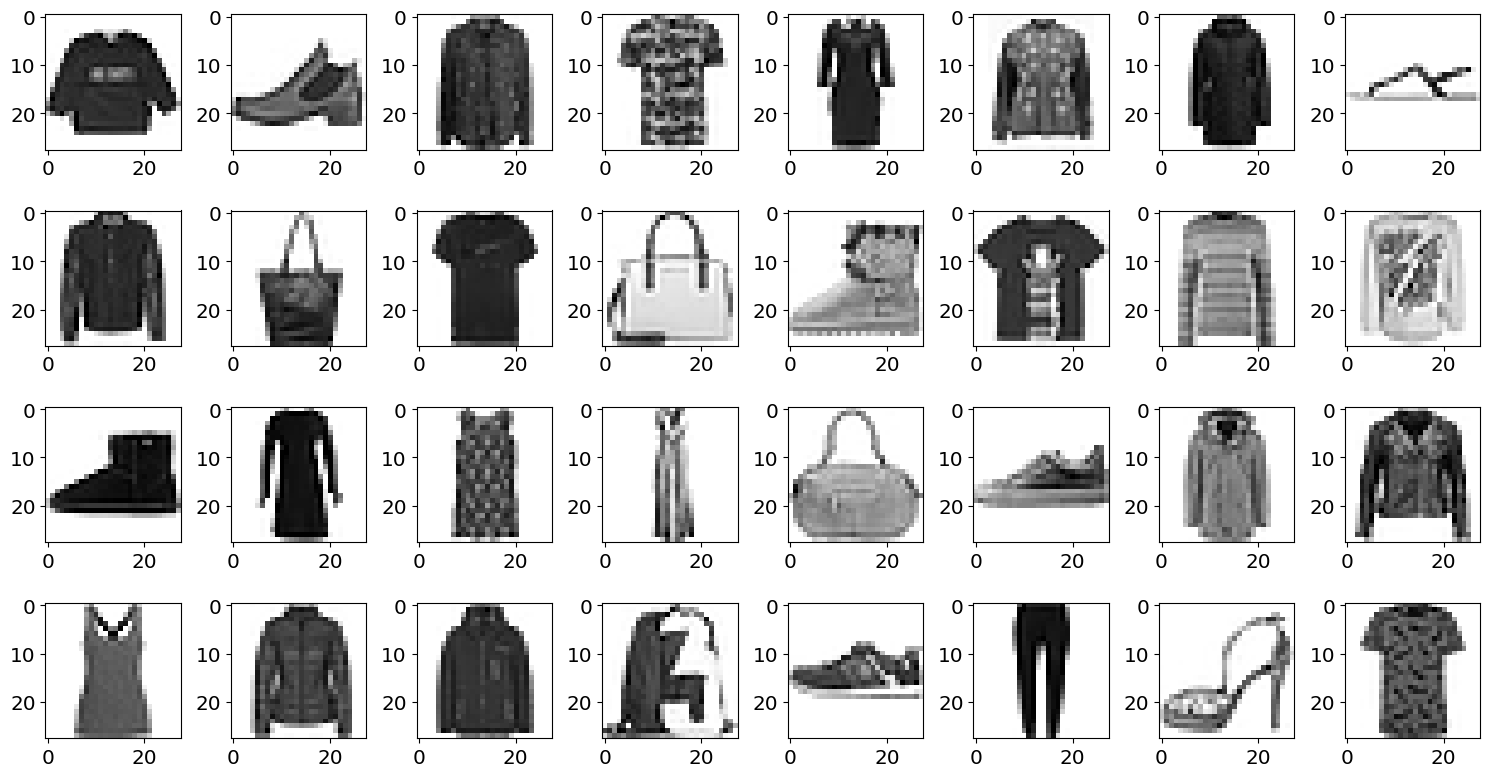

In [13]:
for images, labels in train_ds.take(1):
    
    #print(images.shape, labels)
    
    for i in range(BATCH_SIZE):
    
        rows = 4
        
        plt.subplot(4, BATCH_SIZE//rows, i+1)
        
        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary) # type: ignore
        plt.grid(False)
        
    plt.tight_layout()

2023-12-04 12:53:18.935160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [10000,785]
	 [[{{node Placeholder/_0}}]]


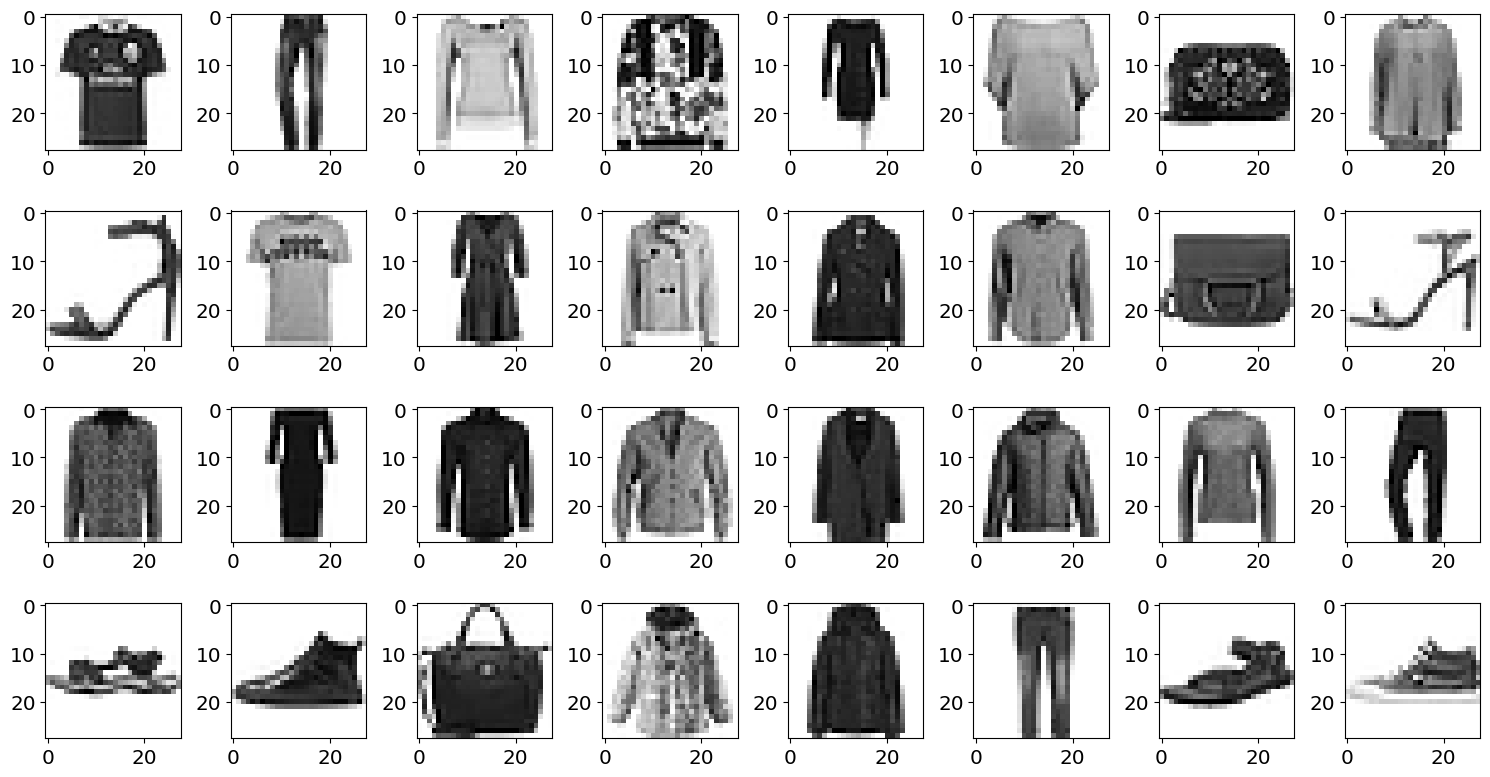

In [14]:
for images, labels in test_ds.take(1):
    
    #print(images.shape, labels)
    
    for i in range(BATCH_SIZE):
    
        rows = 4
        
        plt.subplot(4, BATCH_SIZE//rows, i+1)
        
        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary) # type: ignore
        plt.grid(False)
        
    plt.tight_layout()

In [15]:
#images[0]

In [16]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
dor1 = 0


    
model = tf.keras.Sequential([
    
    tf.keras.layers.Rescaling(1/255.), #28, 28, 3
    
    ###-------
    ### Set 1
    ###-------
    
    tf.keras.layers.Conv2D(32, (3,3),
                            padding = 'same',
                            activation = 'relu',
                            input_shape = (29, 28, 1)), # 28 x 28 x 32
    ###---------                     
    ### Pooling
    ###---------
    
    tf.keras.layers.MaxPooling2D((2, 2)), # 14 x 14 x 32
    
    ###-------
    ### Set 2
    ###-------
    # Conv layer
    tf.keras.layers.Conv2D(64, (3,3),
                            padding = 'same',
                            activation = 'relu'), # 12 x 12 x 24
                     
    ### Pooling
    
    tf.keras.layers.MaxPooling2D((2, 2)), # 6 x 6 x 64
    
    ###-------
    ### Set 3
    ###-------
    # Conv 3
    tf.keras.layers.Conv2D(128, (3,3),
                            padding = 'same',
                            activation = 'relu'), # 4 x 4 x 128
    
    tf.keras.layers.Flatten(),

    ###--------------
    ### Dense Layers
    ###--------------
    # Dense 1
    tf.keras.layers.Dense(512, activation = 'relu'),
    
    #Dense 2
    tf.keras.layers.Dense(10)
    
])



In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    mode = 'auto',
    baseline = None,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=0,
)
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto',
    
)


In [25]:
optim = tf.keras.optimizers.Adam(learning_rate = ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model.compile(optimizer = optim, loss = loss_fn, metrics = ['accuracy'])

In [26]:
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, verbose = 1,batch_size=BATCH_SIZE,
                    callbacks=[early_stopping, lr_decay])

Epoch 1/10


2023-12-04 12:58:58.426137: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 358/1875 [====>.........................] - ETA: 3:45 - loss: 0.5909 - accuracy: 0.7822

KeyboardInterrupt: 

In [ ]:
loss_df = pd.DataFrame(history.history)

In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 50

ax = axes[0]
y1 = loss_df.columns[0]
y2 = loss_df.columns[2]

loss_df.plot( y = [y1, y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]
y1 = loss_df.columns[1]
y2 = loss_df.columns[3]
loss_df[-l_range:].plot( y = [y1, y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.set_title(y1.capitalize())
ax.grid();
plt.tight_layout()

In [ ]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]